In [30]:
# importing libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [31]:
# importing data
df = pd.read_csv('../2.Downloading data/processed_high_impact_outages.csv', parse_dates=['Start', 'Finish'])
df = df.replace({r"\r|\n": " "}, regex=True)
df.columns = df.columns.str.replace(r'[\r\n]', ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
df = df.drop(columns=['Status_Description_Market', 'Market_Notice_Code', 'Impact_Region'])
df = df[df['Unplanned?'] != 1]

# filter the duration hours, only if there are expected outages, and non-outlier values
df = df[(df['Duration_Hours'] <= 1000) &(df['Duration_Hours'] != 0)]
df.head(5)

,Region,NSP,Start,Finish,Network Asset,Recall_Day_Hours,Recall_Night_Hours,Project Work?,Unplanned?,DNSP Aware?,Generator Aware?,Inter-Regional,Status_Description,Status_Code,Reason,Duration_Hours,Impact,file_name
0,NSW,Transgrid,2021-08-30 06:05:00,2021-09-01 12:00:00,Armidale - Dumaresq (8C) 330 kV Line,3.0,4.0,0,0,0,0,1,In Progress,PTP,Commissioning,52.8,<<UPDATED since the last notification>> A cre...,2021-08-30
1,QLD,Powerlink,2021-09-01 08:30:00,2021-09-01 12:00:00,Ross No.4 288/138/19 kV Transformer,1.0,0.0,0,0,1,0,0,Planned,MTLTP,Maintenance,3.5,This is a high impact outage because the recal...,2021-08-30
2,NSW,Transgrid,2021-09-04 06:00:00,2021-09-05 17:00:00,Liddell to Muswellbrook (83) 330 kV Line,4.0,4.0,0,0,1,0,1,Planned,MTLTP,Commissioning,36.0,A credible contingency event during this plann...,2021-08-30
3,SA,ElectraNet,2021-09-06 08:00:00,2021-09-12 08:15:00,Heywood - South East No.1 275 kV Line,159.0,159.0,0,0,0,0,1,Planned,SUBMIT,Commissioning,144.0,<<NEW since the last notification>> A credibl...,2021-08-30
4,QLD,Powerlink,2021-09-06 08:30:00,2021-09-10 16:00:00,Ross No.3 288/138/19 kV Transformer,4.0,6.0,0,0,1,0,0,Planned,MTLTP,Maintenance,103.2,This is a high impact outage because the recal...,2021-08-30


In [32]:
# df['Region'].value_counts()

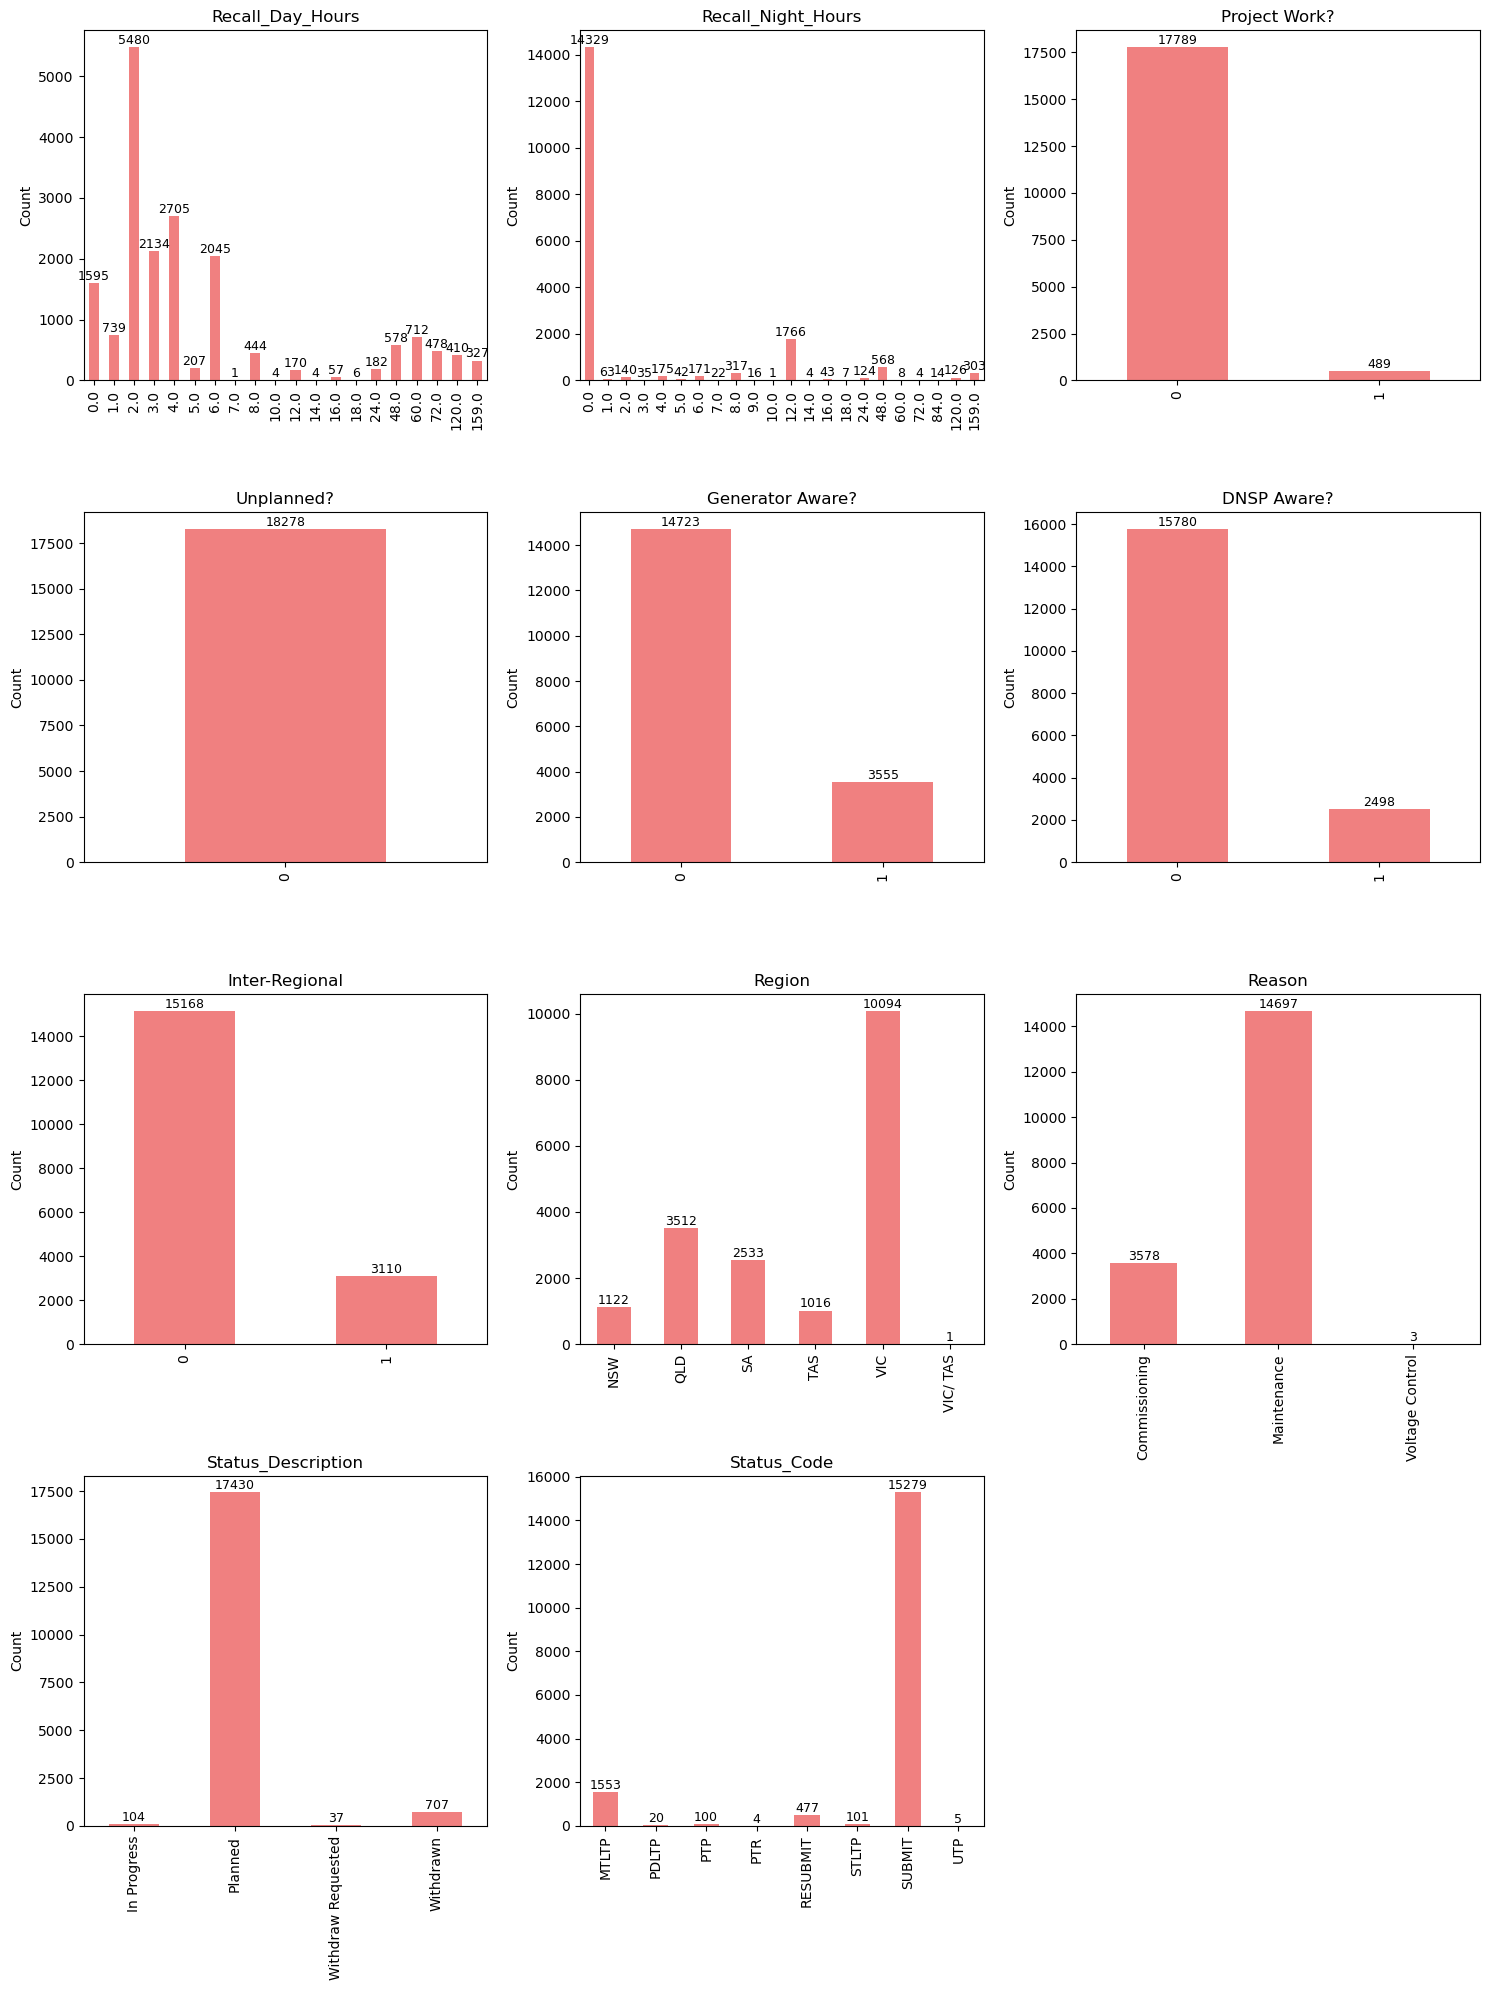

In [33]:
# Visualisation plots for the variables

bool_cols = ['Project Work?', 'Unplanned?', 'Generator Aware?', 'DNSP Aware?', 'Inter-Regional']
numeric_cols = ['Recall_Day_Hours', 'Recall_Night_Hours']
categorical_cols = ['Region', 'Reason', 'Status_Description', 'Status_Code']

# Combine all into one list
all_cols = numeric_cols + bool_cols + categorical_cols

n_cols = 3  # number of columns per row
n_rows = (len(all_cols) + n_cols - 1) // n_cols  # compute required rows

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(all_cols):
    ax = axes[idx]

    # Value counts for categorical/boolean/numeric columns
    counts = df[col].value_counts().sort_index()

    # Plot bar chart
    counts.plot(kind='bar', ax=ax, color='lightcoral')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

    # Add value labels on bars
    for i, value in enumerate(counts):
        ax.text(i, value + 1, str(int(value)), ha='center', va='bottom', fontsize=9, rotation=0)

# Remove any unused subplots
for j in range(len(all_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

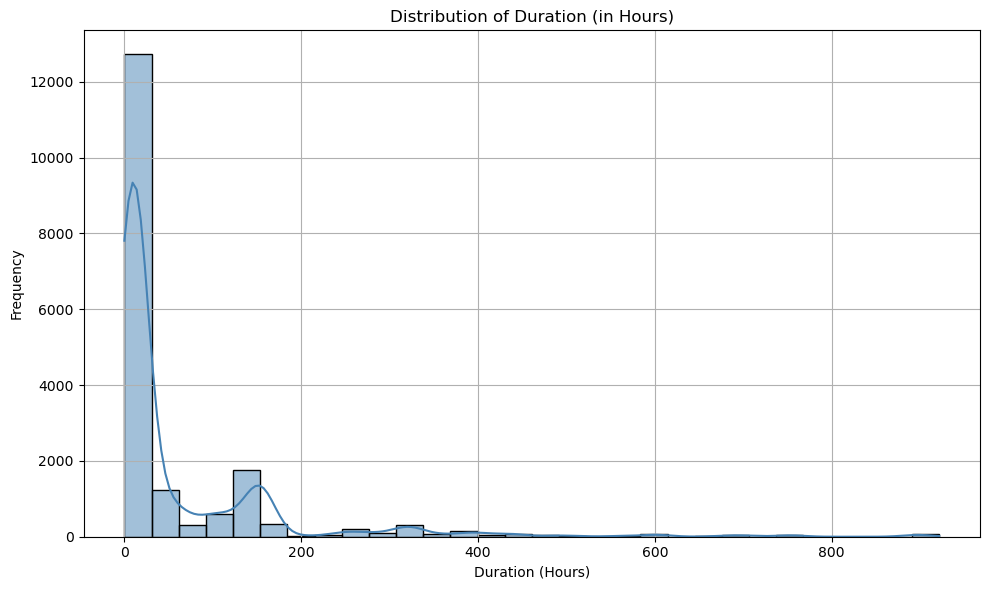

In [34]:
# Plot distribution of output variable 
# Drop NaNs
duration_data = df["Duration_Hours"].dropna()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(duration_data, bins=30, kde=True, color='steelblue')
plt.title("Distribution of Duration (in Hours)")
plt.xlabel("Duration (Hours)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [36]:
# Drop rows with missing Duration_Hours
df = df.dropna(subset=["Duration_Hours"])

# Define target and input variables, dropping some not needed variables.
y = df["Duration_Hours"]

# Drop columns not useful or that leak the target
X = df.drop(columns=["Duration_Hours", 
                     "Start", "Finish", "Network Asset", "Impact", "file_name"])

# Identify categorical and numeric features
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), categorical_cols),
    ],
    remainder='passthrough'  # keep numeric columns as they are
)

# Create pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Region', 'NSP',
                                                   'Status_Description',
                                                   'Status_Code',
                                                   'Reason'])])),
                ('regressor', LinearRegression())])

In [37]:
# from sklearn.ensemble import RandomForestRegressor
# model = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
# ])

In [38]:
import statsmodels.api as sm

# Preprocess
X_encoded = preprocessor.fit_transform(X)

# Ensure the result is a dense NumPy array (statsmodels requires it)
if hasattr(X_encoded, "toarray"):
    X_encoded = X_encoded.toarray()


# Train-test split
X_train_encoded, X_test_encoded, y_train_, y_test_ = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Add constant for intercept
X_train_encoded_const = sm.add_constant(X_train_encoded)

# Fit model
ols_model = sm.OLS(y_train_, X_train_encoded_const).fit()

# Print summary
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     377.5
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        01:26:48   Log-Likelihood:                -87249.
No. Observations:               14622   AIC:                         1.745e+05
Df Residuals:                   14598   BIC:                         1.747e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        119.1132     18.143      6.565      0.0

RMSE: 93.412


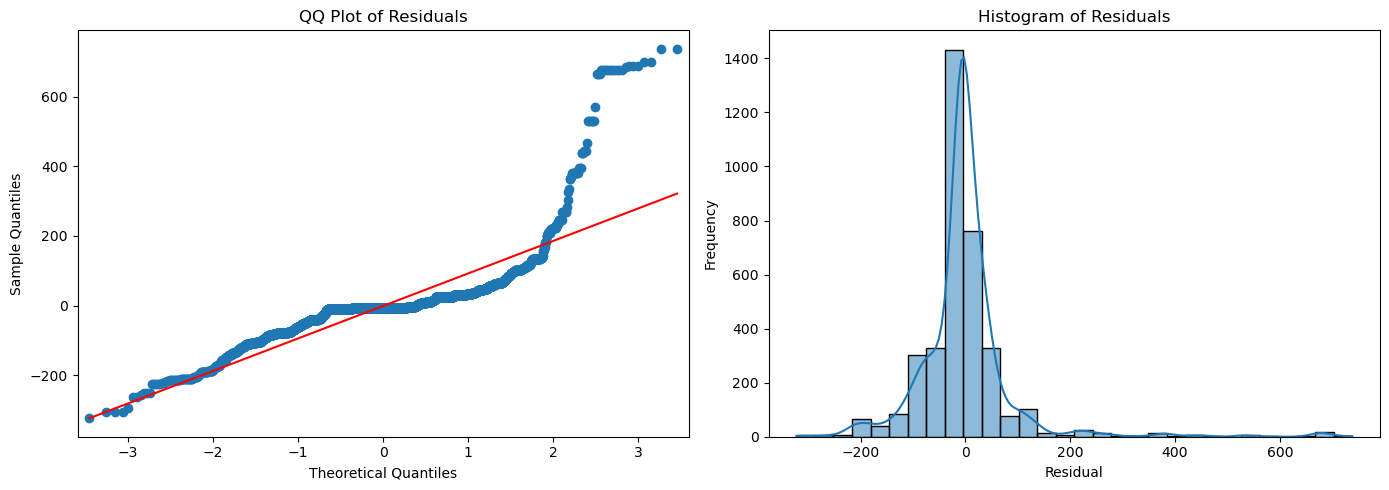

In [39]:


def plot_ols_diagnostics(model, X_test, y_test, X_is_encoded=True):
    # If X_test is not yet encoded and needs to go through the preprocessor
    if not X_is_encoded:
        X_test = preprocessor.transform(X_test)

    # Convert sparse matrix to dense if needed
    if hasattr(X_test, "toarray"):
        X_test = X_test.toarray()

    # Add constant
    X_test_const = sm.add_constant(X_test)

    # Predictions
    y_pred = model.predict(X_test_const)

    # Residuals
    residuals = y_test - y_pred

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse:.3f}")

    # QQ-Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sm.qqplot(residuals, line='s', ax=axes[0])
    axes[0].set_title("QQ Plot of Residuals")

    # Residual Histogram
    sns.histplot(residuals, kde=True, ax=axes[1], bins=30)
    axes[1].set_title("Histogram of Residuals")
    axes[1].set_xlabel("Residual")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()
plot_ols_diagnostics(ols_model, X_test_encoded, y_test_)

In [40]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)
model.fit(X_train_encoded, y_train_)

Ridge()

In [41]:
def ridge_model_summary_with_plots(model, X_train, y_train, X_test, y_test, feature_names=None):
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Residuals
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    # Coefficients
    if feature_names is None:
        feature_names = [f"X{i}" for i in range(X_train.shape[1])]

    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": model.coef_
    }).sort_values(by="Coefficient", key=np.abs, ascending=False)

    print("Ridge Regression Model Summary")
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"R² Score (Train): {r2_train:.4f}")
    print(f"R² Score (Test):  {r2_test:.4f}")
    print(f"RMSE (Train):     {rmse_train:.4f}")
    print(f"RMSE (Test):      {rmse_test:.4f}")
    print("\nTop Coefficients:")
    print(coef_df.head(10).to_string(index=False))

    # Plot residuals
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].scatter(y_train_pred, residuals_train, alpha=0.5)
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_title("Train: Predictions vs Residuals")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Residuals")

    axs[1].scatter(y_test_pred, residuals_test, alpha=0.5)
    axs[1].axhline(0, color='red', linestyle='--')
    axs[1].set_title("Test: Predictions vs Residuals")
    axs[1].set_xlabel("Predicted")
    axs[1].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

    return coef_df

Ridge Regression Model Summary
Intercept: 171.3843
R² Score (Train): 0.3729
R² Score (Test):  0.3532
RMSE (Train):     94.4514
RMSE (Test):      93.3963

Top Coefficients:
                        Feature  Coefficient
        cat__Reason_Maintenance  -134.890074
    cat__Reason_Voltage Control  -115.010819
           cat__Status_Code_PTP   111.882413
             cat__NSP_Transgrid   -87.094261
           cat__Status_Code_PTR   -67.505054
                 cat__Region_SA    58.241736
            cat__NSP_ElectraNet    58.241736
         cat__Status_Code_PDLTP   -44.949957
           cat__Status_Code_nan   -32.073375
cat__Status_Description_Planned   -31.175085


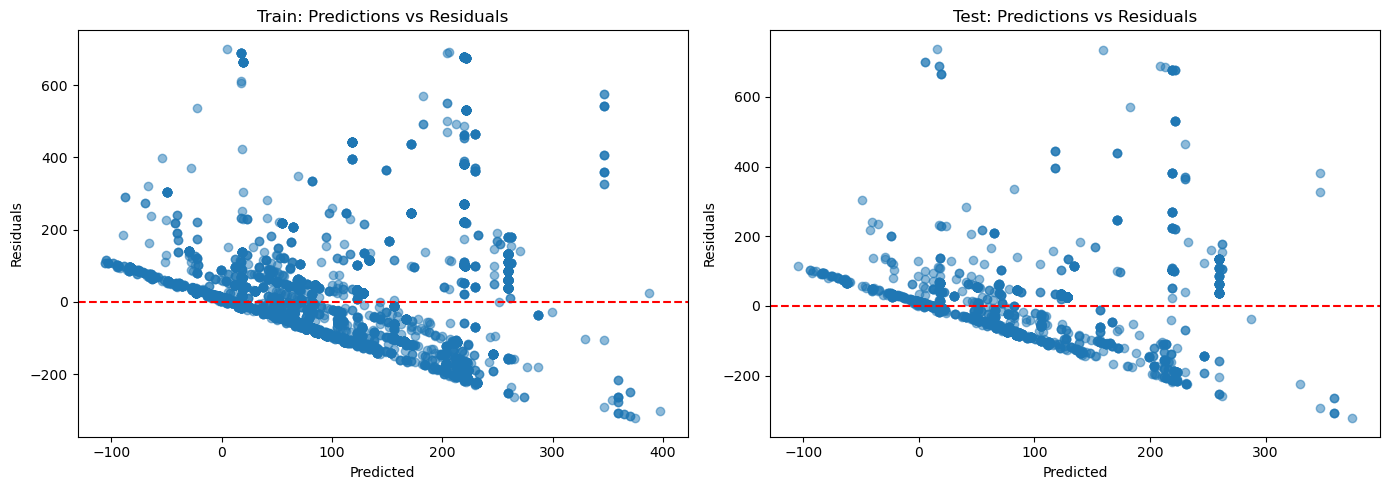

,Feature,Coefficient
21,cat__Reason_Maintenance,-134.890074
22,cat__Reason_Voltage Control,-115.010819
14,cat__Status_Code_PTP,111.882413
9,cat__NSP_Transgrid,-87.094261
15,cat__Status_Code_PTR,-67.505054
1,cat__Region_SA,58.241736
5,cat__NSP_ElectraNet,58.241736
13,cat__Status_Code_PDLTP,-44.949957
20,cat__Status_Code_nan,-32.073375
10,cat__Status_Description_Planned,-31.175085


In [42]:
ridge_model_summary_with_plots(
    model,
    X_train_encoded,
    y_train_,
    X_test_encoded,
    y_test_,
    feature_names=preprocessor.get_feature_names_out()  # Optional if you have it
)